In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm

In [66]:
device = torch.device("cuda")
def model_eval(model, data_loader, return_preds = False):
  model.eval()
  y_preds = []
  y_true = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      y_preds.append(outputs)
      y_true.append(labels)

  y_preds = torch.cat(y_preds).cpu().detach().numpy()
  y_true = torch.cat(y_true).cpu().detach().numpy()

  if return_preds:
    return {'y_true': y_true, 'y_preds': y_preds}
  else:
    return roc_auc_score(y_true, y_preds)

In [67]:
################################
#### Clean and Process Data ####
################################

data = 'TRs_annotated_cleaned.csv'
df = pd.read_csv(data)

col_names = df.columns
categorical = [var for var in df.columns if df[var].dtype=='O']
numerical = [var for var in df.columns if df[var].dtype!='O']

df.drop(['id', 'location', 'region', 'tissue_simple'], axis=1, inplace=True)

one_hot_gene_type = pd.get_dummies(df.gene_type, prefix="gene_type", drop_first=True, dtype=int)
new_df = pd.concat([df[numerical], one_hot_gene_type], axis=1)
new_df.drop(['gene_type_intergenic'], axis=1, inplace=True)

X = new_df.drop(['label'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 32)

# List of column names
all_columns = X.columns

# List to store column names where all values are 0 or 1
binary_columns = []

# Iterate over each column
for column in all_columns:
    unique_values = X[column].unique()
    # Check if unique values contain only 0 and 1
    if set(unique_values) == {0, 1}:
        binary_columns.append(column)

numeric_columns = [elem for elem in all_columns if elem not in binary_columns]

# Create a ColumnTransformer to apply different transformations to numeric and binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), numeric_columns),
        ('binary', 'passthrough', binary_columns)
    ])

# Define the pipeline with the preprocessing steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the training data
X_train_processed = pipeline.fit_transform(X_train)

# Transform the test data using the fitted pipeline
X_test_processed = pipeline.transform(X_test)

# Convert the processed data back to DataFrame (optional)
X_train_processed = pd.DataFrame(X_train_processed, columns=numeric_columns + binary_columns)
X_test_processed = pd.DataFrame(X_test_processed, columns=numeric_columns + binary_columns)

In [68]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create a PyTorch dataset and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [69]:
# Split into val and train to moitor overfitting during training
torch.manual_seed(42)
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [70]:
# Find outcome rates
ys = []
for inputs, labels in train_loader:
  ys.append(labels)

ys = torch.cat(ys)
print('Outcome rate in Training:', torch.mean(ys).detach().numpy().round(3))

ys = []
for inputs, labels in val_loader:
  ys.append(labels)

ys = torch.cat(ys)
print('Outcome rate in Validation:', torch.mean(ys).detach().numpy().round(3))

ys = []
for inputs, labels in test_loader:
  ys.append(labels)

ys = torch.cat(ys)
print('Outcome rate in Testing:', torch.mean(ys).detach().numpy().round(3))

Outcome rate in Training: 0.151
Outcome rate in Validation: 0.151
Outcome rate in Testing: 0.155


In [71]:
class MLP(nn.Module):
    def __init__(self, dropout):
        super(MLP, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        self.fc1 = nn.LazyLinear(500, bias=False)
        self.bn1 = nn.BatchNorm1d(500)

        self.fc2 = nn.Linear(500, 1000, bias=False)
        self.bn2 = nn.BatchNorm1d(1000)

        self.fc3 = nn.Linear(1000, 500, bias=False)
        self.bn3 = nn.BatchNorm1d(500)

        self.fc4 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.sigmoid(self.fc4(x))
        return x.squeeze(1)


In [43]:
torch.manual_seed(1)
model = MLP(0.5)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=500, bias=False)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=1000, bias=False)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=False)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
)

In [44]:
epoch_val_roc = []
epoch_train_roc = []
best_auc = 0
counter = 0
EARLY_STOP = np.inf

In [ ]:
# Define loss function and optimizer
### OOPS! Just realized nn.CrossEntropyLoss() expects raw logits not the predicted probabilities will rerun later to see if results change
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    train_auc = model_eval(model, train_loader)
    val_auc = model_eval(model, val_loader)

    epoch_train_roc.append(train_auc)
    epoch_val_roc.append(val_auc)

    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    if val_auc > best_auc:
      best_auc = val_auc
      torch.save(model.state_dict(), '/content/drive/MyDrive/BMI 776 Final Project/Results/Models/Neural Network/V2/best_model.pth')
    else:
      counter += 1

    if counter == EARLY_STOP:
      print(f'No increase in validation AUC in {EARLY_STOP} iterations. Ending Training')
      break

100%|██████████| 1000/1000 [2:18:45<00:00,  8.33s/it]


In [ ]:
print('Train AUC:', model_eval(model, train_loader))
print('Validation AUC:', model_eval(model, val_loader))
print('Test AUC:', model_eval(model, test_loader))

Train AUC: 0.9564344396334755
Validation AUC: 0.8707039656592234
Test AUC: 0.8630461891238306


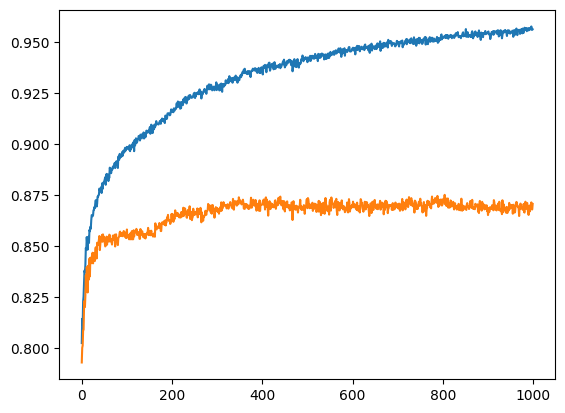

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1000), epoch_train_roc)
plt.plot(epoch_val_roc);

In [ ]:
# Load the model from a file
best_model = MLP(0.5)
# best_model.load_state_dict(torch.load('/content/drive/My Drive/BMI 776 Final Project/Results/Models/Neural Network/model_epoch545.pth'))
best_model.load_state_dict(torch.load('/content/drive/My Drive/BMI 776 Final Project/Results/Models/Neural Network/V2/best_model.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
print('Train AUC:', model_eval(best_model, train_loader))
print('Validation AUC:', model_eval(best_model, val_loader))
print('\nTest AUC:', model_eval(best_model, test_loader))

Train AUC: 0.9523566134749147
Validation AUC: 0.8751574989471124

Test AUC: 0.8666606304820599


## Evalute Feature Importance

I'm not sure how to evalate feature importance with neural networks. I just followed an online guide from the all-knowing medium articles: https://romainlhardy.medium.com/estimating-feature-importance-the-easy-way-2ebe970c600c

Basically, you rearrange/shuffle one column at a time and calulate how much that affects your auc

In [ ]:
def get_feature_importance(model, feature_j, n, X_test, y_test):
  model.eval()
  y_pred = model(X_test).detach().numpy()
  s = roc_auc_score(y_true, y_pred) # baseline score
  total = 0.0
  for i in range(n):
    perm = np.random.permutation(range(X_test.shape[0]))
    X_test_ = X_test.detach().numpy().copy()
    X_test_[:, feature_j] = X_test[perm, feature_j]
    y_pred_ = model(torch.tensor(X_test_)).detach().numpy()
    s_ij = roc_auc_score(y_true, y_pred_)
    total += s_ij
  return s - total / n

In [ ]:
from tqdm import tqdm

In [ ]:
# Feature importances
f = []
y_true, y_preds = model_eval(best_model, test_loader, return_preds=True).values()
for j in tqdm(range(X_test.shape[1])):
  f_j = get_feature_importance(best_model, j, 100, X_test_tensor, y_test_tensor.detach().numpy())
  f.append(f_j)

100%|██████████| 56/56 [53:07<00:00, 56.92s/it]


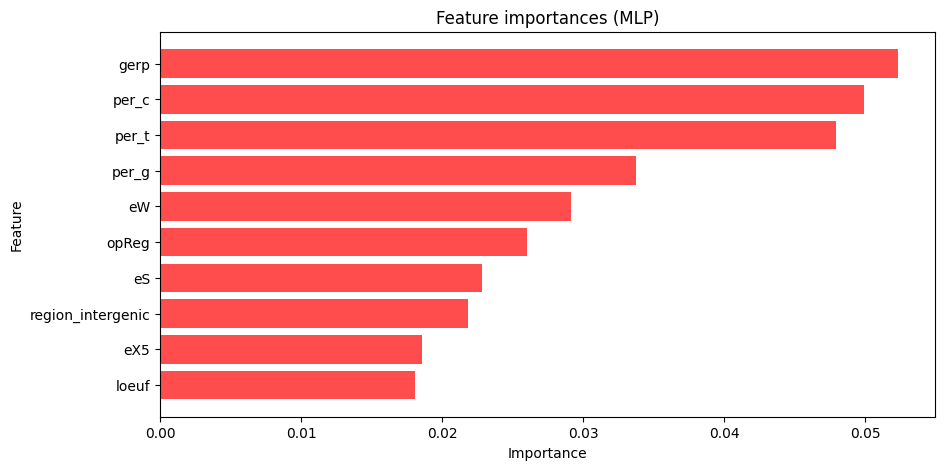

In [ ]:
# Assuming f contains the feature importances and X_test_processed.columns contains the feature names
# Get the indices of the top 10 features
top10_indices = np.argsort(f)[-10:][::-1]

# Initialize lists to store top 10 features and importances
top10_features = []
top10_importances = []

# Extract the top 10 features and their importances
for idx in top10_indices:
    top10_features.append(X_test_processed.columns[idx])
    top10_importances.append(f[idx])

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top10_features, top10_importances, color="r", alpha=0.7)  # Flipped x and y coordinates
plt.xlabel("Importance")  # Flipped x and y labels
plt.ylabel("Feature")  # Flipped x and y labels
plt.title("Feature importances (MLP)")
plt.gca().invert_yaxis()  # Invert the y-axis to order bars from tallest to shortest
plt.show()

In [72]:
# Rebuilding model with all data, defining train set
X_trainAll_processed = pipeline.fit_transform(X)
X_trainAll_processed = pd.DataFrame(X_trainAll_processed, columns=numeric_columns + binary_columns)
X_trainAll_tensor = torch.tensor(X_trainAll_processed.values, dtype=torch.float32)
y_trainAll_tensor = torch.tensor(y.values, dtype=torch.float32)

trainAll_dataset = TensorDataset(X_trainAll_tensor, y_trainAll_tensor)

trainAll_loader_full = DataLoader(trainAll_dataset, batch_size=batch_size, shuffle=True)


leave_one_out_data = 'Mistra_TRs_annotated_cleaned.csv'
df2 = pd.read_csv(leave_one_out_data)
df2.drop(['id', 'location', 'region', 'tissue_simple'], axis=1, inplace=True)


numerical2 = [var for var in df2.columns if df2[var].dtype!='O']
one_hot_gene_type2 = pd.get_dummies(df2.gene_type, prefix="gene_type", drop_first=False, dtype=int)
new_df2 = pd.concat([df2[numerical2], one_hot_gene_type2], axis=1)

columns_to_add = ['antisense', 'lincRNA', 'polymorphic_pseudogene', 'processed_transcript', 'protein_coding', 'pseudogene', 'sense_overlapping']
column_names = ['gene_type_' + columns_to_add[i] for i in range(7)]
new_df2.drop(['gene_type_intergenic', 'eTr1'], axis=1, inplace=True)
new_df2 = new_df2.assign(**{col: 0 for col in column_names})

new_df2 = new_df2[['gene_distance', 'gerp', 'TAD', 'eSTR', 'opReg', 'promoter', 'UTR_3',
       'UTR_5', 'loeuf', 'pLi', 'RAD21', 'SMC3', 'per_g', 'per_c', 'per_a',
       'per_t', 'gc_content', 'eSh0', 'eSh1', 'eSh2', 'eSh3', 'eSh4', 'eSh5',
       'eTr0', 'eTr2', 'eTr3', 'eTr4', 'eTr5', 'eH', 'eW', 'eS6', 'eS', 'J',
       'eX0', 'eX1R', 'eX2', 'eX3', 'eX4', 'eX5',
       'tissue_simple_No_expression', 'tissue_simple_Nervous_System',
       'tissue_simple_Other', 'region_intergenic', 'region_intron',
       'region_exon', 'location_First', 'location_Middle', 'location_Last', 'gene_type_Unknown', 'gene_type_antisense',
       'gene_type_lincRNA', 'gene_type_polymorphic_pseudogene',
       'gene_type_processed_transcript', 'gene_type_protein_coding',
       'gene_type_pseudogene', 'gene_type_sense_overlapping']]
X_mistra = pipeline.fit_transform(new_df2)
X_mistra = pd.DataFrame(X_mistra, columns=numeric_columns + binary_columns)
X_mistra_tensor = torch.tensor(X_mistra.values, dtype=torch.float32)

mistra_dataset = TensorDataset(X_mistra_tensor)

mistra_loader_full = DataLoader(X_mistra_tensor, batch_size=64, shuffle=False)  # You might not need to shuffle for evaluation

In [87]:
torch.manual_seed(1)
modelAll = MLP(0.5)
modelAll

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=500, bias=False)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=1000, bias=False)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=False)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
)

In [88]:
epoch_val_roc = []
epoch_train_roc = []
best_auc = 0
counter = 0
EARLY_STOP = np.inf

In [89]:
# Define loss function and optimizer
### OOPS! Just realized nn.CrossEntropyLoss() expects raw logits not the predicted probabilities will rerun later to see if results change
criterion = nn.BCELoss()
optimizer = optim.Adam(modelAll.parameters(), lr=0.001)
modelAll.to(device)

# Train the model
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    modelAll.train()
    running_loss = 0.0
    for inputs, labels in trainAll_loader_full:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = modelAll(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainAll_loader_full.dataset)
    modelAll.eval().cuda()
    train_auc = model_eval(modelAll, trainAll_loader_full)

    epoch_train_roc.append(train_auc)


  0%|          | 0/1000 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [49]:
torch.save(model.state_dict(), '/content/drive/My Drive/BMI 776 Final Project/Results/Models/Neural Network/V2/full_model.pth')

In [63]:
model1 = MLP(0.5)
model1_path = '/content/drive/My Drive/BMI 776 Final Project/Results/Models/Neural Network/V2/best_model.pth'
model1.load_state_dict(torch.load(model1_path))
device = 'cpu'
model_eval(model1, trainAll_loader_full)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.9154952002577652

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([0.1364774704, 0.0262843799, 0.0013037799,  ..., 0.0402316824,
        0.0063642217, 0.9745565057])
Mean: 0.1678962
Standard Deviation: 0.25059593


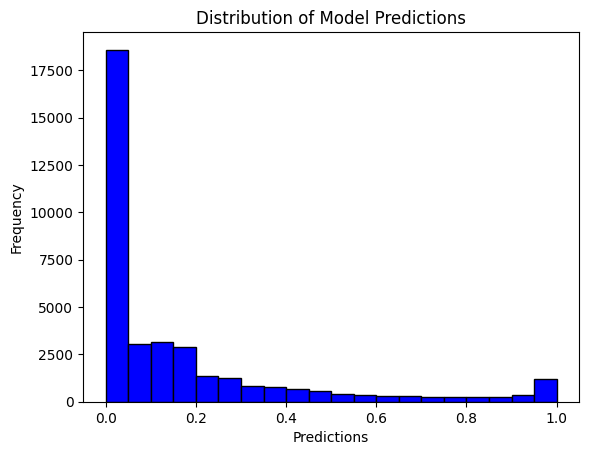

In [95]:
modelAll = MLP(0.5)
modelAll
modelAll_path = '/content/drive/My Drive/BMI 776 Final Project/Results/Models/Neural Network/V2/best_model.pth'
modelAll.load_state_dict(torch.load(modelAll_path))

all_outputs = []
modelAll.eval()

# Iterate over the data loader
for batch,y in trainAll_loader_full:
    # Forward pass
    with torch.no_grad():  # We don't need gradients during evaluation
        predictions = modelAll(batch)
    # Append the predictions to the list of all outputs
    all_outputs.append(predictions)

# Concatenate all the outputs into a single tensor
outputs = torch.cat(all_outputs, dim=0)
print(outputs)
outputs.size
predictions_array = outputs.numpy()

# Print mean and standard deviation
print("Mean:", np.mean(predictions_array))
print("Standard Deviation:", np.std(predictions_array))

# Print histogram
import matplotlib.pyplot as plt

plt.hist(predictions_array, bins=20, color='blue', edgecolor='black')
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of Model Predictions')
plt.show()

torch.save(predictions_array, '/content/drive/My Drive/BMI 776 Final Project/Data/predictions_array')


In [74]:

# Initialize an empty list to store the model predictions
all_outputs = []

# Set the model to evaluation mode
modelAll.eval()

# Iterate over the data loader
for batch in mistra_loader_full:
    # Extract the input tensor from the batch
    # Forward pass
    with torch.no_grad():  # We don't need gradients during evaluation
        predictions = modelAll(batch)
    # Append the predictions to the list of all outputs
    all_outputs.append(predictions)

# Concatenate all the outputs into a single tensor
outputs = torch.cat(all_outputs, dim=0)
print(outputs)

# Set the model to evaluation mode
modelAll.eval()




tensor([4.5793e-05, 1.8079e-01, 4.3652e-03, 1.0411e-01, 4.2049e-08, 1.6073e-01,
        6.7030e-09, 2.2658e-01, 1.6429e-02, 1.2903e-06, 5.8145e-02, 1.3644e-02,
        4.3841e-01, 4.3775e-03, 9.9782e-01, 5.3227e-03, 2.9164e-06, 1.1289e-02,
        1.7529e-09, 1.2908e-01, 8.2546e-08, 1.1634e-03, 1.3231e-03, 8.0574e-03,
        4.0668e-03, 1.2728e-04, 5.8043e-03, 3.0532e-01, 5.7955e-09, 3.6027e-01,
        4.6344e-09, 3.5714e-05, 1.9651e-04, 1.7421e-09])


MLP(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=0, out_features=500, bias=False)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=1000, bias=False)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=False)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
)

In [97]:
rounded_output = torch.round(outputs, decimals = 3)
print(rounded_output)
torch.save(rounded_output,'/content/drive/My Drive/BMI 776 Final Project/Data/rounded_output')

tensor([0.1360000074, 0.0260000005, 0.0010000000,  ..., 0.0399999991,
        0.0060000001, 0.9750000238])
